# Practical intro to Quantum Chemistry

## with Orca!

[![](images/orca.png)](https://orcaforum.cec.mpg.de/)


### Requirements / Bare-bones:

* [**Orca 3.0.3**](https://orcaforum.cec.mpg.de/).
* Python 2 or 3, with [Ipython/Jupyter](https://jupyter.org/) notebook abilities. 
* Python modules: *matplotlib, imolecule, openbabel*.

### Recomended / Good stuff to check out
 
* [**Orca Manual**](https://orcaforum.cec.mpg.de/OrcaManual.pdf).
* [**Orca Input Library**](https://sites.google.com/site/orcainputlibrary/).
* A sweet sweet text editor, I suggest [**Sublime Text**](http://www.sublimetext.com/).
* Molecular visualizer, [**Avogadro**](http://avogadro.cc/wiki/Main_Page) is good and easy and [**VMD**](http://www.ks.uiuc.edu/Research/vmd/) is powerful.

## Quantum Chemistry

Quantum chemistry is a mix of physics, chemistry, and applied mathematics and computation.

In Quantum Chemistry try to solve either the time-independent Schrödinger equation (stationary states)
to get molecular properties:
$$
H | \psi \rangle = E | \psi \rangle,
$$
or time-dependent:
$$
i\hbar \frac{\partial \Psi}{\partial t} = -\frac{\hbar^2}{2m}
\frac{\partial^2 \Psi}{\partial x^2} + V \Psi
$$

Relevant quotes:

> “We can calculate everything"
> - Enrico Clementi


## Input files

Almost all quantum chemistry packages work with input files, which are text files with a few key words that indicate which model we will use for a calculation.

Here is an example input file


In [1]:
!head input.inp

! DFT cc-pVDZ

*xyzfile 0 1 mol.xyz



### Some questions that arise when doing calculations:

* What software should I use?
* Is my algorithm parallelized?
* Which geometry?
* Which methodology should I use?
* DFT or Wavefunction methods? or Quantum Monte Carlo?
* Open or Closed Shell?
* Multireference wavefunction?
* How accurate and how much can I trust my calculations?
* How do I treat a solvated molecule? Which solvation model?
* Do I need to incorporate dispersion effects?
* Which basis set should I use?
* Polarization, Diffusion functions?
* Spin coupling effects?

Most decisions are coupled so you really can't test each independently.

Like a fellow quantum chemist said, sometimes you just got to do science and just marry whichever of what works best for you!

## The Quantum Chemistry Panorama (stationary)
### So what does this all mean?
![](images/overview.png)

#### The main problem is treating electron-electron interactions.

### To summarize:

* **DFT:** Based on charge density, a physical measurable, pretty cheap $\mathcal{O}(n^3)-\mathcal{O}(n^4)$ and accurate, not 100% reliable. You have to decide on a functional and a basis set. Also **the Hohenberg-Kohn theorems** state that any molecular property can be derived from the charge density and there exists a universal functional which will solve all your problems.
* **Wavefunction:** Pretty expensive $\mathcal{O}(n^3)-\mathcal{O}(n!)$, but reliable and there is a clear idea of how to systematically improve your solution and to arrive to the exact theoretical limit. Sometimes you can 

* **Semi-empirical:** Relies on force fields, parameterizations, model-fitting and other neat tricks to get cheap and semi accurate results for a fraction of the cost. 


## First is First
### Choose you favorite molecule!*
#### * of 10 electrons or less

### XYZ geometry files
Contains basic 3d coordinates of a molecule

1. Number of atoms
2. Comment line, can be whatever
3. Atom # 1, Element X Y Z

... follow till N atoms

**Now** make a xyz file, name it **mol.xyz**, you will use this molecule for your exploration

In [4]:
!head mol.xyz

3
Water Molecule!
H          0.63109       -0.02651        0.47485
O          0.14793        0.02998       -0.34219
H         -0.77901       -0.00348       -0.13266

In [5]:
import imolecule
imolecule.draw("mol.xyz")

## Run a calculation
Assuming you installed Orca correctly, you can run your calculations as show below via the command:
```bash
orca inputfile > outputfile
```
should take only a few seconds..

In [14]:
!orca input.inp > output.out

let's check out our output file

In [15]:
!tail -50 output.out

         implemented in ORCA!
For a nonlinear molecule the correct rotational entropy is:
    S(rot) = R*(ln(qrot/sn)+1.5)
    R    = 8.31441 J/mol/K = 1.987191683e-3 kcal/mol/K
    qrot =   91.7685093
    sn is the rotational symmetry number. We have assumed 3 here
       if it is different for your molecule then you should correct
       the printed rotational entropy by manually evaluating the equation
       as given above

For convenience we print out the resulting values for sn=1 - 12:
 sn= 1  qrot/sn=      91.7685 T*S(rot)=     3.57 kcal/mol T*S(tot)=    13.89 kcal/mol
 sn= 2  qrot/sn=      45.8843 T*S(rot)=     3.16 kcal/mol T*S(tot)=    13.48 kcal/mol
 sn= 3  qrot/sn=      30.5895 T*S(rot)=     2.92 kcal/mol T*S(tot)=    13.24 kcal/mol
 sn= 4  qrot/sn=      22.9421 T*S(rot)=     2.74 kcal/mol T*S(tot)=    13.07 kcal/mol
 sn= 5  qrot/sn=      18.3537 T*S(rot)=     2.61 kcal/mol T*S(tot)=    12.93 kcal/mol
 sn= 6  qrot/sn=      15.2948 T*S(rot)=     2.50 kcal/mol T*S(tot)=    12

Output files are large, so we normally use the magic of programming to extract the information:
#### Grep
Via command line you can use [**grep**](http://www.tecmint.com/12-practical-examples-of-linux-grep-command/) (globally search a regular expression and print), you use like this:
```shell
grep string file
```
Care about energy?

In [16]:
!grep 'FINAL SINGLE POINT ENERGY' output.out

FINAL SINGLE POINT ENERGY       -75.775648427445
FINAL SINGLE POINT ENERGY       -75.777039332221
FINAL SINGLE POINT ENERGY       -75.777123331293
FINAL SINGLE POINT ENERGY       -75.777148006512
FINAL SINGLE POINT ENERGY       -75.777148108679


time?

In [17]:
!grep 'TOTAL RUN TIME:' output.out

TOTAL RUN TIME: 0 days 0 hours 0 minutes 6 seconds 685 msec


### Better yet, some Python magic
For now a poor man's grep

In [18]:
def findStrings(afile,substr):
    lines=[]
    with open(afile) as astr:
        for line in astr:
            if substr in line:
                 lines.append(line)
    return lines

In [19]:
findStrings('output.out','FINAL SINGLE POINT ENERGY')

['FINAL SINGLE POINT ENERGY       -75.775648427445\n',
 'FINAL SINGLE POINT ENERGY       -75.777039332221\n',
 'FINAL SINGLE POINT ENERGY       -75.777123331293\n',
 'FINAL SINGLE POINT ENERGY       -75.777148006512\n',
 'FINAL SINGLE POINT ENERGY       -75.777148108679\n']

In [20]:
def findFinalEnergy(afile):
    lines=[]
    substr='FINAL SINGLE POINT ENERGY'
    with open(afile) as astr:
        for line in astr:
            if substr in line:
                tmpline=line.replace(substr,'').strip()
                lines.append(float(tmpline))
    return lines[-1]

In [21]:
findFinalEnergy('output.out')

-75.777148108679

#### Now computing time

In [22]:
def findComputeTime(afile):
    timestr=''
    substr='TOTAL RUN TIME:'
    milisecs=0
    # find string with time
    with open(afile) as astr:
        for line in astr:
            if substr in line:
                timestr=line.replace(substr,'').strip()
    # there is probably a better way of doing this
    timestr=timestr.split()
    milisecs+=int(timestr[-2]) #milisecs
    milisecs+=1000*int(timestr[-4]) #seconds
    milisecs+=60000*int(timestr[-6]) #minutes
    milisecs+=60*60*1000*int(timestr[-8]) #hours
    milisecs+=24*60*60*1000*int(timestr[-10]) #days

    return milisecs

In [23]:
findComputeTime('output.out')

6685

### Also CCLIB
From the website: http://cclib.github.io/
>cclib is an open source library, written in Python, for parsing and interpreting the results of computational chemistry packages.
>

## Wavefunction methods
### Now to compute!


We are interested in time, accuracy and cost.

Explore the following methods:
* PM3
* Hartree Fock
* MP2
* CCSD
* CCSD(T)
* DLPNO-CCSD
Use the basis set **cc-pVDZ**

And save the energy and times in a dictionary

In [25]:
!orca input.inp > output.out

In [26]:
!tail output.out



Timings for individual modules:

Sum of individual times         ...        1.266 sec (=   0.021 min)
GTO integral calculation        ...        0.128 sec (=   0.002 min)  10.1 %
SCF iterations                  ...        1.002 sec (=   0.017 min)  79.1 %
MP2 module                      ...        0.137 sec (=   0.002 min)  10.8 %
                             ****ORCA TERMINATED NORMALLY****
TOTAL RUN TIME: 0 days 0 hours 0 minutes 1 seconds 355 msec


In [58]:
from collections import OrderedDict
energy = OrderedDict()
time = OrderedDict()

## One last trick!
### Template text replacing for automatic input creation
#### and calculation

1. First we define a list of varying parameters within a input file
2. Define a replace function, which takes a template text file and replaces all instances into a new file
3. Iterate over each variable, create input and calculate!



In [29]:
methods=['PM3','HF','MP2','CCSD','CCSD(T)','DLPNO-CCSD']

In [30]:
def replace_all(astr, bstr, dict):
    with open(astr, 'r') as afile:
        with open(bstr, 'w') as bfile:
            data = afile.read()
            for key, value in dict.items():
                data = data.replace(key, str(value))
            bfile.write(data)
    return

In [31]:
import os

for method in methods:
    replaceDict={"#{METHOD}":method}
    replace_all('template_method.inp','input.inp', replaceDict)
    os.system('orca input.inp > %s.out'%method)

# Whoa!
## you just calculated 50 years of quantum chemistry in a few minutes!
### now plot energy and time for each method

In [59]:
methods=['HF','MP2','CCSD']
for method in methods:
    replaceDict={"#{METHOD}":method}
    replace_all('template_method.inp','input.inp', replaceDict)
    outFile='%s.out'%method
    os.system('orca input.inp > %s'%outFile)
    energy[method]=findFinalEnergy(outFile)
    time[method]=findComputeTime(outFile)

In [36]:
energy

OrderedDict([('PM3', -596.679470069436), ('HF', -76.026723267945), ('MP2', -76.227611674261), ('CCSD', -76.237203049244)])

In [41]:
time

OrderedDict([('PM3', 337), ('HF', 1623), ('MP2', 487), ('CCSD', 696)])

In [62]:
energy

OrderedDict([('HF', -76.026723271909), ('MP2', -76.227611691149), ('CCSD', -76.237203049108)])

['HF', 'MP2', 'CCSD']


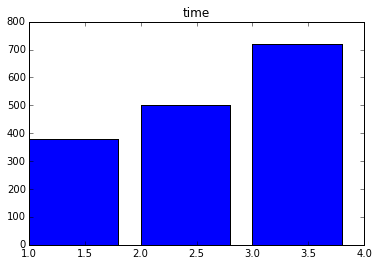

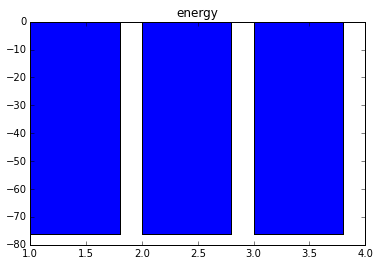

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline 

print(methods)
plt.title("time")
plt.bar([1,2,3],[val[1] for val in time.items()])
plt.show()

plt.title("energy")
plt.bar([1,2,3],[val[1] for val in energy.items()])
plt.show()

## DFT functionals

DFT functionals more or less go across what is called Jacob's ladder:
![](images/jacobladderextra.png)

### Now try one function of each class:

* Local
* Gradient corrected (GGA)
* Meta GGA
* Hybrid or hybrid meta GGA
* Perturbatively corrected double hybrid

Plot compute time and energy

In [68]:
!orca input.inp > output.out

In [67]:
!tail -50 output.out



                            ***************************************
                            *     ORCA property calculations      *
                            ***************************************


           used in the property calculations are still SCF densities
           MP2 response densities have not been calculated 
           use %mp2 Density relaxed end
           or  %mp2 Density unrelaxed end

                                    ---------------------
                                    Active property flags
                                    ---------------------
   (+) Dipole Moment


------------------------------------------------------------------------------
                       ORCA ELECTRIC PROPERTIES CALCULATION
------------------------------------------------------------------------------

Dipole Moment Calculation                       ... on
Quadrupole Moment Calculation                   ... off
Polarizability Calculation                      ... o

## extra: Basis set effects
### with wavefunctions

Compute using your favorite wavefunction method the following basis set:
* cc-pVDZ
* cc-pVTZ
* cc-pVQZ
* cc-pV5Z

### with DFT
Compute using your favorite functional method the following basis set:
* Def2-SV
* Def2-QDVP
* Def2-TZV
* Def2-QZVP

## finally..
So now you know how to do a massive number of calculations, It might feel a bit mechanistic sometimes.. so it's good to remember
> 
"..Computers don‘t solve problems - people do!“
> - Ernest R Davidson
